In [29]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.feature_selection import mutual_info_regression
import json

In [30]:
df = pd.read_csv('training_data.csv')
df['YearMonth'] = pd.to_datetime(df['YearMonth'])

In [31]:
# Export zipcode scores to JSON
zipcodes = df['zipcode'].unique()
results = []
evaluation_metrics = []

In [32]:
for zipcode in df['zipcode'].unique():
    zipcode_data = df[df['zipcode'] == zipcode].sort_values('YearMonth')
    if len(zipcode_data) < 24: 
        continue
    
    prophet_df = zipcode_data[['YearMonth', 'AveragePrice']].rename(columns={'YearMonth': 'ds', 'AveragePrice': 'y'})
    
    additional_features = ['ArrestCount', 'NoiseComplaints', 'distance_to_facility',
                           'cultural_facility', 'education_facility', 'health_services',
                           'public_safety', 'recreational_facility', 'religious_institution',
                           'transportation_facility', 'population', 'average_household_income']
    
    X = zipcode_data[additional_features]
    y = zipcode_data['AveragePrice']
    
    # Select features
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    selected_features = mi_scores.head(10).index.tolist()
    
    for feature in selected_features:
        prophet_df[feature] = zipcode_data[feature]
    
    # Fit and predict Prophet
    model = Prophet(yearly_seasonality=True, daily_seasonality=False, changepoint_prior_scale=0.05)
    
    for feature in selected_features:
        model.add_regressor(feature)
    
    model.fit(prophet_df)
    
    future = model.make_future_dataframe(periods=60, freq='ME')
    
    for feature in selected_features:
        x = np.arange(len(prophet_df[feature]))
        y = prophet_df[feature].values
        A = np.vstack([x, np.ones(len(x))]).T
        m, c = np.linalg.lstsq(A, y, rcond=None)[0]
        future_values = m * (np.arange(len(prophet_df[feature]), len(prophet_df[feature]) + 60)) + c
        future[feature] = np.concatenate([prophet_df[feature], future_values])
    
    forecast = model.predict(future)
    
    current_price = prophet_df['y'].iloc[-1]
    last_date = prophet_df['ds'].iloc[-1]
    
    roi_results = {}
    for year in [1, 3, 5]:
        forecast_date = last_date + pd.DateOffset(years=year)
        forecast_index = (forecast['ds'] - forecast_date).abs().argsort()[0]
        
        future_price = forecast['yhat'].iloc[forecast_index]
        roi = (future_price - current_price) / current_price
        roi_lower = (forecast['yhat_lower'].iloc[forecast_index] - current_price) / current_price
        roi_upper = (forecast['yhat_upper'].iloc[forecast_index] - current_price) / current_price
        
        roi_results[f'{year}Yr_ROI'] = roi
        roi_results[f'{year}Yr_ROI_Lower'] = roi_lower
        roi_results[f'{year}Yr_ROI_Upper'] = roi_upper
        roi_results[f'{year}Yr_forecast_price'] = future_price
    
    result = {
        'zipcode': int(zipcode),
        'borough': zipcode_data['Borough'].iloc[0],
        'current_price': float(current_price),
        **{key: float(value) for key, value in roi_results.items()}
    }
    results.append(result)

    # Calculate evaluation metrics (not saved to results)
    historical_forecast = forecast[:len(prophet_df)]
    mae = mean_absolute_error(prophet_df['y'], historical_forecast['yhat'])
    rmse = np.sqrt(mean_squared_error(prophet_df['y'], historical_forecast['yhat']))
    r2 = r2_score(prophet_df['y'], historical_forecast['yhat'])
    mape = np.mean(np.abs((prophet_df['y'] - historical_forecast['yhat']) / prophet_df['y'])) * 100
    
    evaluation_metrics.append({
        'zipcode': int(zipcode),
        'MAE': float(mae),
        'RMSE': float(rmse),
        'R²': float(r2),
        'MAPE': float(mape)
    })

16:31:36 - cmdstanpy - INFO - Chain [1] start processing
16:31:36 - cmdstanpy - INFO - Chain [1] done processing
16:31:37 - cmdstanpy - INFO - Chain [1] start processing
16:31:37 - cmdstanpy - INFO - Chain [1] done processing
16:31:38 - cmdstanpy - INFO - Chain [1] start processing
16:31:38 - cmdstanpy - INFO - Chain [1] done processing
16:31:39 - cmdstanpy - INFO - Chain [1] start processing
16:31:39 - cmdstanpy - INFO - Chain [1] done processing
16:31:40 - cmdstanpy - INFO - Chain [1] start processing
16:31:40 - cmdstanpy - INFO - Chain [1] done processing
16:31:42 - cmdstanpy - INFO - Chain [1] start processing
16:31:43 - cmdstanpy - INFO - Chain [1] done processing
16:31:44 - cmdstanpy - INFO - Chain [1] start processing
16:31:44 - cmdstanpy - INFO - Chain [1] done processing
16:31:45 - cmdstanpy - INFO - Chain [1] start processing
16:31:46 - cmdstanpy - INFO - Chain [1] done processing
16:31:47 - cmdstanpy - INFO - Chain [1] start processing
16:31:47 - cmdstanpy - INFO - Chain [1]

In [33]:
# Analysis of results
results_df = pd.DataFrame(results)
evaluation_df = pd.DataFrame(evaluation_metrics)

print("Summary statistics of evaluation metrics:")
print(evaluation_df[['MAE', 'RMSE', 'R²', 'MAPE']].describe())

print("\nTop 5 zipcodes by 5-year ROI:")
top_5_roi = results_df.sort_values('5Yr_ROI', ascending=False).head()
top_5_roi_with_metrics = top_5_roi.merge(evaluation_df, on='zipcode')
print(top_5_roi_with_metrics[['zipcode', 'borough', 'current_price', '1Yr_ROI', '3Yr_ROI', '5Yr_ROI', 'R²']])

print("\nBottom 5 zipcodes by 5-year ROI:")
bottom_5_roi = results_df.sort_values('5Yr_ROI').head()
bottom_5_roi_with_metrics = bottom_5_roi.merge(evaluation_df, on='zipcode')
print(bottom_5_roi_with_metrics[['zipcode', 'borough', 'current_price', '1Yr_ROI', '3Yr_ROI', '5Yr_ROI', 'R²']])

Summary statistics of evaluation metrics:
                MAE          RMSE          R²      MAPE
count    165.000000    165.000000  165.000000  1.000000
mean    7134.580174   9533.314209    0.984373  1.322066
std     7236.055850   9326.349557    0.075165       NaN
min       13.295219     28.143632    0.302944  1.322066
25%     3114.432422   4163.350251    0.989399  1.322066
50%     4393.098384   6077.786930    0.996585  1.322066
75%     8229.711649  11219.826257    0.998737  1.322066
max    44308.392305  55580.556844    0.999830  1.322066

Top 5 zipcodes by 5-year ROI:
   zipcode    borough  current_price   1Yr_ROI   3Yr_ROI   5Yr_ROI        R²
0    11692     Queens       559920.0  0.093588  0.257204  0.431833  0.995737
1    10039  Manhattan       613826.0  0.127645  0.262716  0.413230  0.983212
2    11436     Queens       603401.0  0.093697  0.210843  0.328800  0.998867
3    10454      Bronx       701282.0  0.104894  0.204582  0.304134  0.989227
4    11239   Brooklyn       609447.0  

In [34]:
with open('zipcode_scores.json', 'w') as f:
    json.dump(results, f, indent=4)

# For plotting

In [35]:
# Analysis for a specific borough and max price
borough = 'Brooklyn'
max_price = 2000000

borough_results = [r for r in results if r['borough'] == borough and r['current_price'] <= max_price]
for r in borough_results:
    r['Average_ROI'] = (r['1Yr_ROI'] + r['3Yr_ROI'] + r['5Yr_ROI']) / 3

top_zipcodes = sorted(borough_results, key=lambda x: x['Average_ROI'], reverse=True)[:5]
top_zipcodes_df = pd.DataFrame(top_zipcodes)

print(f"Top 5 Zipcodes in {borough} under ${max_price:,}:")
print(top_zipcodes_df[['zipcode', 'current_price', '1Yr_ROI', '3Yr_ROI', '5Yr_ROI']])

Top 5 Zipcodes in Brooklyn under $2,000,000:
   zipcode  current_price   1Yr_ROI   3Yr_ROI   5Yr_ROI
0    11239       609447.0  0.065784  0.183057  0.295521
1    11224       524313.0  0.069979  0.166120  0.281670
2    11203       674652.0  0.078273  0.167789  0.250013
3    11212       590614.0  0.067714  0.164455  0.256887
4    11208       650991.0  0.069694  0.154264  0.237596


16:34:31 - cmdstanpy - INFO - Chain [1] start processing
16:34:32 - cmdstanpy - INFO - Chain [1] done processing


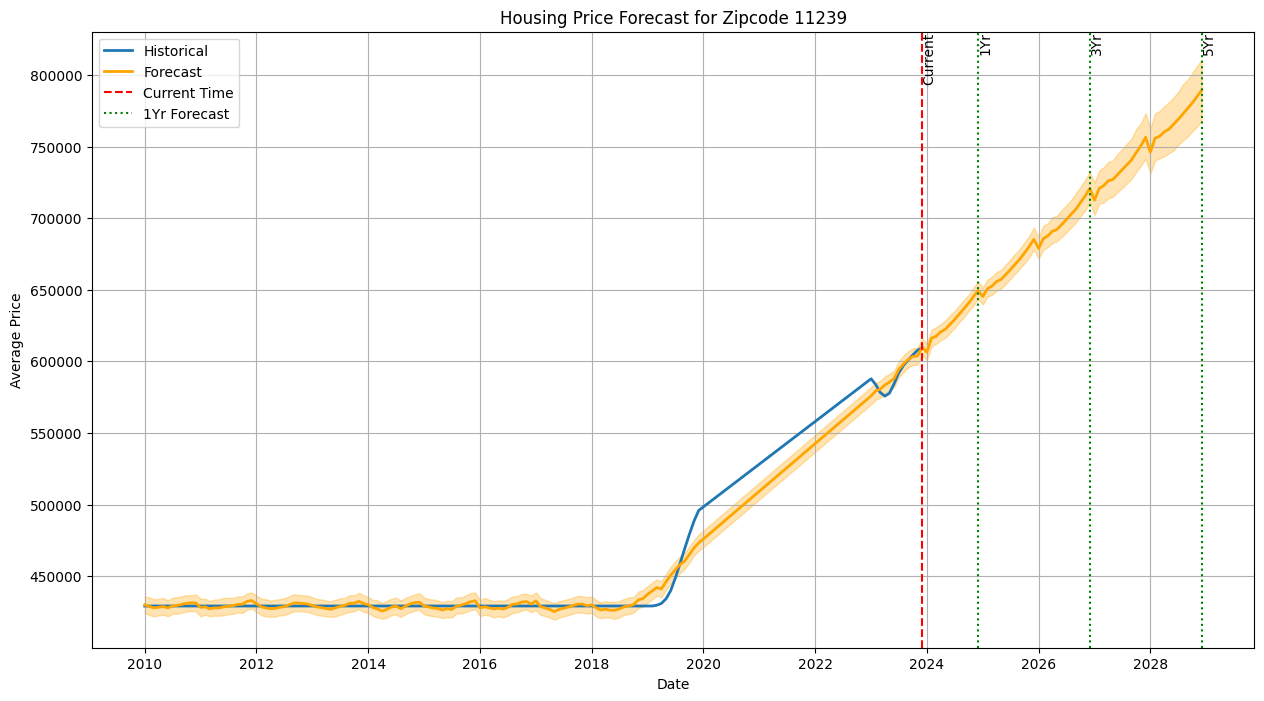


Detailed forecast for zipcode 11239:
1Yr forecast price: $649476.83
1Yr ROI: 6.57%
3Yr forecast price: $720811.65
3Yr ROI: 18.27%
5Yr forecast price: $789163.70
5Yr ROI: 29.49%


16:34:33 - cmdstanpy - INFO - Chain [1] start processing
16:34:34 - cmdstanpy - INFO - Chain [1] done processing


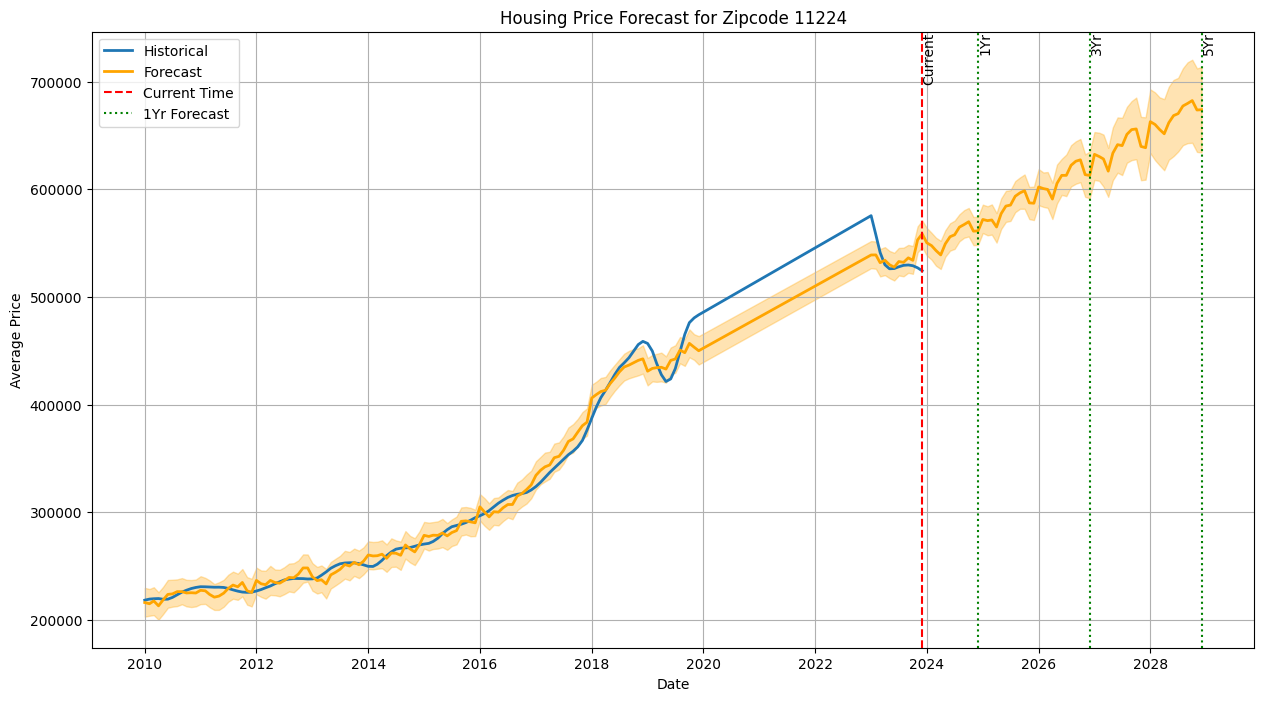


Detailed forecast for zipcode 11224:
1Yr forecast price: $561393.36
1Yr ROI: 7.07%
3Yr forecast price: $612835.36
3Yr ROI: 16.88%
5Yr forecast price: $673963.53
5Yr ROI: 28.54%


16:34:36 - cmdstanpy - INFO - Chain [1] start processing
16:34:36 - cmdstanpy - INFO - Chain [1] done processing


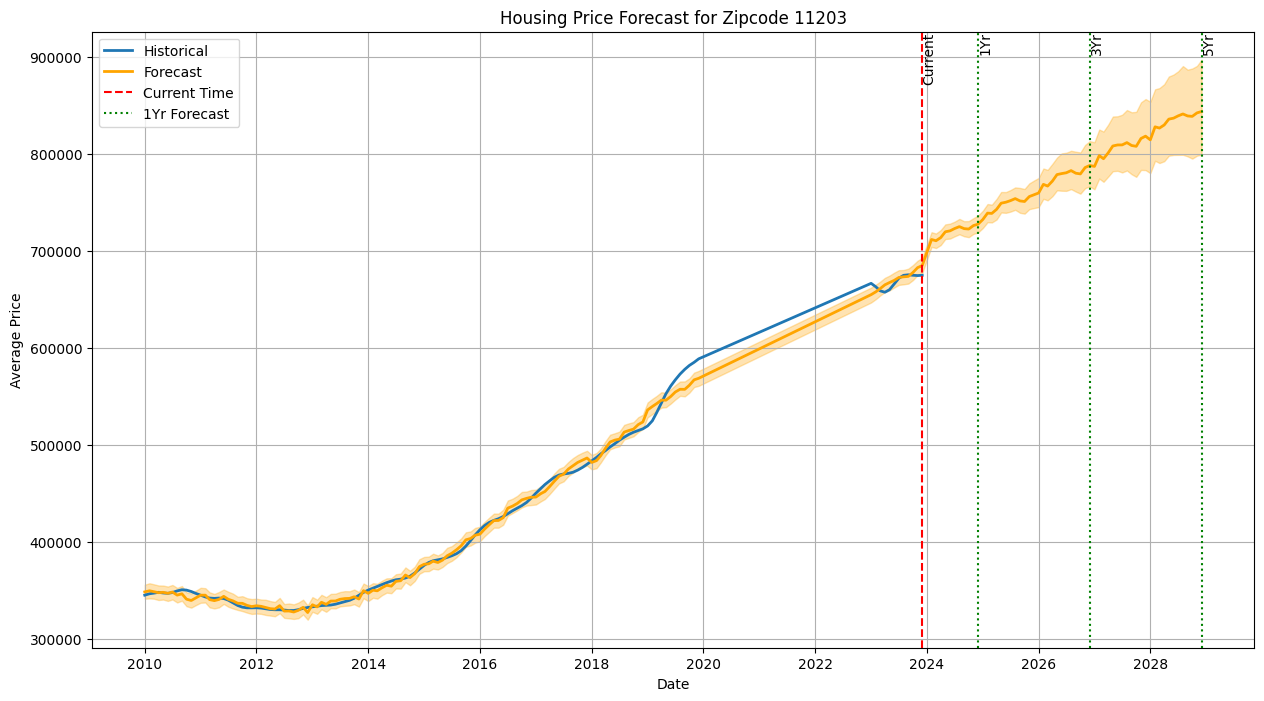


Detailed forecast for zipcode 11203:
1Yr forecast price: $727323.54
1Yr ROI: 7.81%
3Yr forecast price: $787802.94
3Yr ROI: 16.77%
5Yr forecast price: $843401.30
5Yr ROI: 25.01%


16:34:37 - cmdstanpy - INFO - Chain [1] start processing
16:34:38 - cmdstanpy - INFO - Chain [1] done processing


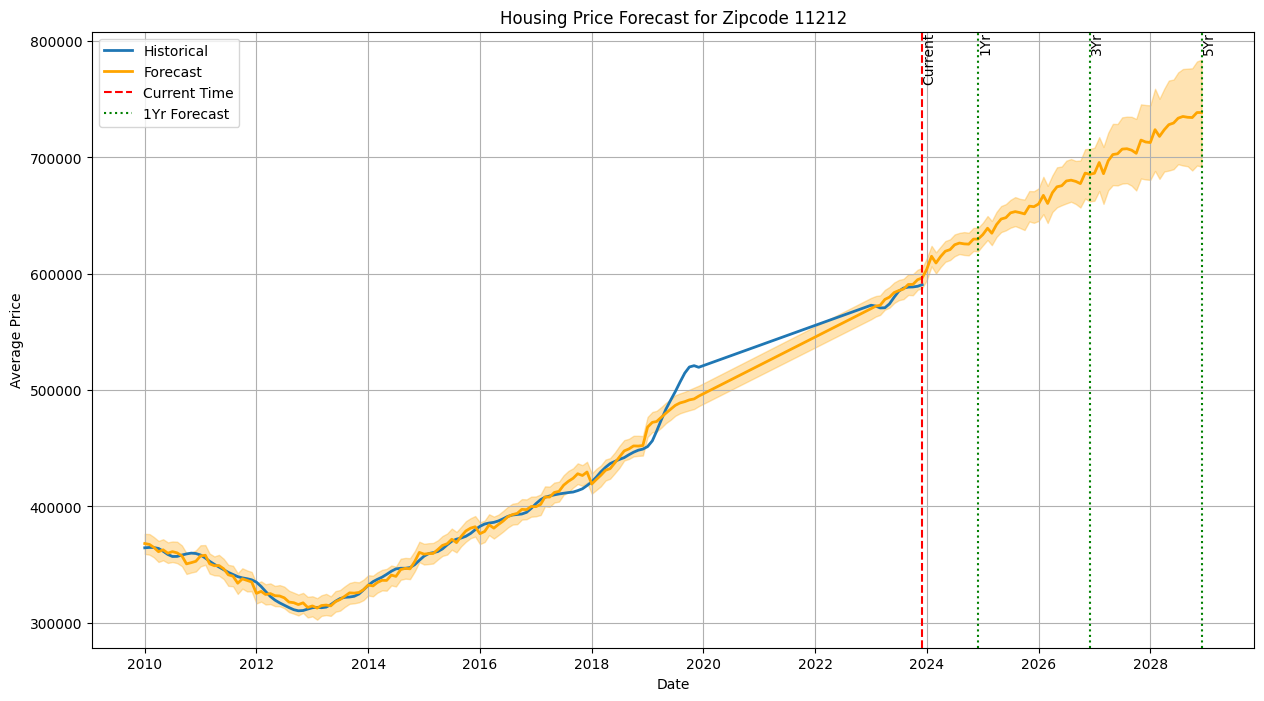


Detailed forecast for zipcode 11212:
1Yr forecast price: $629776.07
1Yr ROI: 6.63%
3Yr forecast price: $685455.10
3Yr ROI: 16.06%
5Yr forecast price: $738580.64
5Yr ROI: 25.05%


16:34:39 - cmdstanpy - INFO - Chain [1] start processing
16:34:39 - cmdstanpy - INFO - Chain [1] done processing


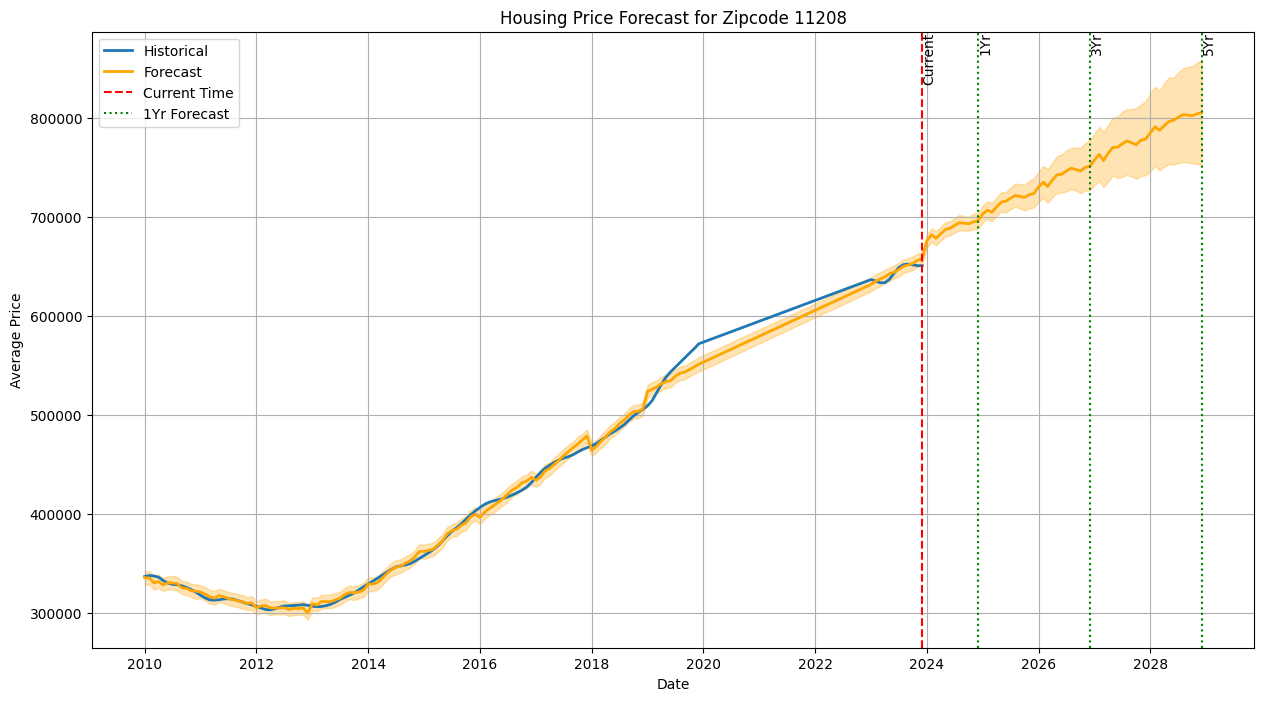


Detailed forecast for zipcode 11208:
1Yr forecast price: $696515.88
1Yr ROI: 6.99%
3Yr forecast price: $751509.77
3Yr ROI: 15.44%
5Yr forecast price: $805732.20
5Yr ROI: 23.77%


In [36]:
# Plotting for top zipcodes
for zipcode in top_zipcodes_df['zipcode']:
    zipcode_data = df[df['zipcode'] == zipcode].sort_values('YearMonth')
    prophet_df = zipcode_data[['YearMonth', 'AveragePrice']].rename(columns={'YearMonth': 'ds', 'AveragePrice': 'y'})
    
    for feature in selected_features:
        prophet_df[feature] = zipcode_data[feature]
    
    model = Prophet(yearly_seasonality=True, daily_seasonality=False, changepoint_prior_scale=0.05)
    for feature in selected_features:
        model.add_regressor(feature)
    model.fit(prophet_df)
    
    future = model.make_future_dataframe(periods=60, freq='ME')
    for feature in selected_features:
        x = np.arange(len(prophet_df[feature]))
        y = prophet_df[feature].values
        A = np.vstack([x, np.ones(len(x))]).T
        m, c = np.linalg.lstsq(A, y, rcond=None)[0]
        future_values = m * (np.arange(len(prophet_df[feature]), len(prophet_df[feature]) + 60)) + c
        future[feature] = np.concatenate([prophet_df[feature], future_values])
    
    forecast = model.predict(future)
    
    plt.figure(figsize=(15, 8))
    plt.plot(prophet_df['ds'], prophet_df['y'], label='Historical', linewidth=2)
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='orange', linewidth=2)
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.3)
    plt.title(f'Housing Price Forecast for Zipcode {zipcode}')
    plt.xlabel('Date')
    plt.ylabel('Average Price')
    plt.legend()
    
    current_time = prophet_df['ds'].iloc[-1]
    plt.axvline(x=current_time, color='r', linestyle='--', label='Current Time')
    plt.text(current_time, plt.ylim()[1], 'Current', rotation=90, verticalalignment='top')
    
    for year in [1, 3, 5]:
        forecast_time = current_time + pd.DateOffset(years=year)
        plt.axvline(x=forecast_time, color='g', linestyle=':', label=f'{year}Yr Forecast' if year == 1 else '')
        plt.text(forecast_time, plt.ylim()[1], f'{year}Yr', rotation=90, verticalalignment='top')
    
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"\nDetailed forecast for zipcode {zipcode}:")
    for year in [1, 3, 5]:
        forecast_date = prophet_df['ds'].iloc[-1] + pd.DateOffset(years=year)
        forecast_index = (forecast['ds'] - forecast_date).abs().argsort()[0]
        forecast_price = forecast['yhat'].iloc[forecast_index]
        roi = (forecast_price - prophet_df['y'].iloc[-1]) / prophet_df['y'].iloc[-1]
        print(f"{year}Yr forecast price: ${forecast_price:.2f}")
        print(f"{year}Yr ROI: {roi:.2%}")